In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('ggplot')
%matplotlib inline

np.random.seed(0)

In [2]:
import keras
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.layers.recurrent import GRU, LSTM
from keras.layers.core import Dense
import keras.backend as K
from keras.utils import np_utils

/Users/prihodad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
batch_size = 4
timesteps = 16
num_features = 3

In [4]:
model = Sequential()

model.add(Bidirectional(
    layer=LSTM(
        units=100,
        return_sequences=True,
        dropout=0.2,
        recurrent_dropout=0.2,
        stateful=True
    ),
    batch_input_shape=(batch_size, timesteps, num_features)
))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

In [5]:
def get_samples(num_samples, batch_size, timesteps, num_features):
    v = np.random.randint(0, num_features, num_samples)
    X = np_utils.to_categorical(v.reshape(-1, 1), num_features)

    X = X.reshape(-1, timesteps, num_features)
    #y = (v == 2).astype(np.int).reshape(-1, timesteps, 1)
    two_is_next = np.append((v[1:] == 2).astype(np.int), 0)
    zero_is_now = (v == 0).astype(np.int)
    y = two_is_next & zero_is_now
    y = y.reshape(-1, timesteps, 1)
    return X, y

In [6]:
X, y = get_samples(2048, batch_size, timesteps, num_features)
print('X: ', X.shape)
print('Y: ', y.shape)
print('First batch element:')
[v for v in zip(X[0], y[0])]

X:  (128, 16, 3)
Y:  (128, 16, 1)
First batch element:


[(array([0., 1., 0.], dtype=float32), array([0])),
 (array([0., 0., 1.], dtype=float32), array([0])),
 (array([1., 0., 0.], dtype=float32), array([1])),
 (array([0., 0., 1.], dtype=float32), array([0])),
 (array([0., 1., 0.], dtype=float32), array([0])),
 (array([0., 0., 1.], dtype=float32), array([0])),
 (array([1., 0., 0.], dtype=float32), array([0])),
 (array([1., 0., 0.], dtype=float32), array([0])),
 (array([1., 0., 0.], dtype=float32), array([1])),
 (array([0., 0., 1.], dtype=float32), array([0])),
 (array([0., 0., 1.], dtype=float32), array([0])),
 (array([0., 0., 1.], dtype=float32), array([0])),
 (array([0., 1., 0.], dtype=float32), array([0])),
 (array([1., 0., 0.], dtype=float32), array([0])),
 (array([1., 0., 0.], dtype=float32), array([0])),
 (array([0., 1., 0.], dtype=float32), array([0]))]

In [7]:
X_val, y_val = get_samples(1024, batch_size, timesteps, num_features)

In [8]:
model.fit(X, y, epochs=5, batch_size=batch_size, validation_data=(X_val, y_val))

Train on 128 samples, validate on 64 samples
Epoch 1/5
128/128 [==============================] - 2s 13ms/step - loss: 0.4374 - acc: 0.8564 - val_loss: 0.3397 - val_acc: 0.8955
Epoch 2/5
128/128 [==============================] - 0s 4ms/step - loss: 0.3309 - acc: 0.8945 - val_loss: 0.3172 - val_acc: 0.8955
Epoch 3/5
128/128 [==============================] - 0s 4ms/step - loss: 0.3140 - acc: 0.8945 - val_loss: 0.3078 - val_acc: 0.8955
Epoch 4/5
128/128 [==============================] - 0s 4ms/step - loss: 0.2937 - acc: 0.8945 - val_loss: 0.2743 - val_acc: 0.8955
Epoch 5/5
128/128 [==============================] - 0s 4ms/step - loss: 0.2513 - acc: 0.8955 - val_loss: 0.2012 - val_acc: 0.8984


In [9]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(true_values, predictions, ax=None, title='ROC', label='ROC', lw=1, **kwargs):
    fpr, tpr, _ = roc_curve(true_values, predictions)
    roc_auc = auc(fpr, tpr)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))

    ax.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
    ax.plot(fpr, tpr, lw=lw, label=label + ': {:.3f} AUC'.format(roc_auc), **kwargs)
    ax.set_title(title)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend(loc='lower right')
    return ax

In [10]:
X_test, y_test = get_samples(512, batch_size, timesteps, num_features)
pred = model.predict(X_test, batch_size=batch_size)

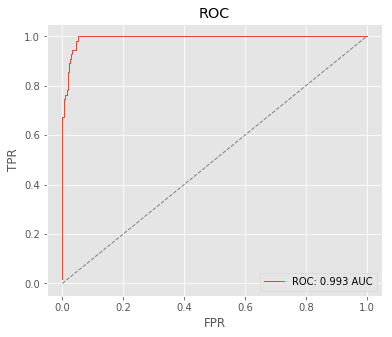

In [12]:
plot_roc_curve(y_test.flatten(), pred.flatten())